In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
%matplotlib inline

BATCH_SIZE = 256
MAX_ITERATION = 100000
LEARNING_RATE = 0.001
DECAY_RATE = 0.01 ** (1 / MAX_ITERATION)
RESIZE_HEIGHT = 32
RESIZE_WIDTH = 32
CLASSES = 43
LEARNING_RATE_DECAY = True
L2_LAMBDA = 0.0001

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [2]:
# Reading into Queues
def read_and_decode_single_example(filename):
    # first construct a queue containing a list of filenames.
    # this lets a user split up there dataset in multiple files to keep
    # size down
    filename_queue = tf.train.string_input_producer([filename],
                                                    num_epochs=None)
    # Unlike the TFRecordWriter, the TFRecordReader is symbolic
    reader = tf.TFRecordReader()
    # One can read a single serialized example from a filename
    # serialized_example is a Tensor of type string.
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
    # now return the converted data
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    image = tf.reshape(image, [RESIZE_HEIGHT, RESIZE_WIDTH, 3])
    # OPTIONAL: Could reshape into a 28x28 image and apply distortions
    # here.  Since we are not applying any distortions in this
    # example, and the next step expects the image to be flattened
    # into a vector, we don't bother.

    # Convert from [0, 255] -> [-0.5, 0.5] floats.
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
    return label, image

In [3]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.get_variable('wc1_', shape=[3, 3, 3, 64], initializer=tf.contrib.layers.xavier_initializer()),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.get_variable('wc2_', shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer()),
    # 5x5 conv, 64 inputs, 128 outputs
    'wc3': tf.get_variable('wc3_', shape=[3, 3, 128, 256], initializer=tf.contrib.layers.xavier_initializer()),
    # 5x5 conv, 128 inputs, 128 outputs
    'wc4': tf.get_variable('wc4_', shape=[3, 3, 256, 256], initializer=tf.contrib.layers.xavier_initializer()),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.get_variable('wd1_', shape=[4 * 4 * 256, 1024], initializer=tf.contrib.layers.xavier_initializer()),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.get_variable('out_w', shape=[1024, CLASSES], initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1': tf.get_variable('bc1_', shape=[64], initializer = tf.constant_initializer(0.0)),
    'bc2': tf.get_variable('bc2_', shape=[128], initializer = tf.constant_initializer(0.0)),
    'bc3': tf.get_variable('bc3_', shape=[256], initializer = tf.constant_initializer(0.0)),
    'bc4': tf.get_variable('bc4_', shape=[256], initializer = tf.constant_initializer(0.0)),
    'bd1': tf.get_variable('bd1_', shape=[1024], initializer = tf.constant_initializer(0.0)),
    'out': tf.get_variable('out_b', shape=[CLASSES], initializer = tf.constant_initializer(0.0))
}

# The percetage of neurons be kept
dropout_p = {
    'conv1_p' : 0.9,
    'conv2_p' : 0.8,
    'conv3_p' : 0.7,
    'conv4_p' : 0.6,
    'fc1_p' : 0.5
}

# Create model
def conv_net(x, weights, biases, is_training):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, RESIZE_HEIGHT, RESIZE_WIDTH, 3])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    # Dropout
    conv1 = tf.cond(is_training, lambda: tf.nn.dropout(conv1, keep_prob = dropout_p['conv1_p']), lambda: conv1)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    # Dropout
    conv2 = tf.cond(is_training, lambda: tf.nn.dropout(conv2, keep_prob = dropout_p['conv2_p']), lambda: conv2)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Dropout
    conv3 = tf.cond(is_training, lambda: tf.nn.dropout(conv3, keep_prob = dropout_p['conv3_p']), lambda: conv3)
    
    # Convolution Layer
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    # Max Pooling (down-sampling)
    conv4 = maxpool2d(conv4, k=2)
    # Dropout
    conv4 = tf.cond(is_training, lambda: tf.nn.dropout(conv4, keep_prob = dropout_p['conv4_p']), lambda: conv4)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv4, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.cond(is_training, lambda: tf.nn.dropout(fc1, keep_prob = dropout_p['fc1_p']), lambda: fc1)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [4]:
# use placeholder for data loading
def data_test_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, test_images.shape[0])
        np.random.shuffle(idxs)
        shuf_features = test_images[idxs, :]
        shuf_labels = test_labels[idxs, ]
        batch_size = BATCH_SIZE
        for batch_idx in range(0, test_images.shape[0], batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size, :]
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size, ]
            labels_batch = np.reshape(labels_batch, (labels_batch.shape[0],))
            yield images_batch, labels_batch

# use placeholder for data loading
def data_train_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        # shuffle labels and features
        idxs = np.arange(0, train_images.shape[0])
        np.random.shuffle(idxs)
        shuf_features = train_images[idxs, :]
        shuf_labels = train_labels[idxs, ]
        batch_size = BATCH_SIZE
        for batch_idx in range(0, train_images.shape[0], batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size, :]
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size, ]
            labels_batch = np.reshape(labels_batch, (labels_batch.shape[0],))
            yield images_batch, labels_batch

## Some useful functions

In [5]:
import sys
import time

def get_time_hhmmss(start = None):
    """
    Calculates time since `start` and formats as a string.
    """
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str   

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

## Loading dataset from image folders

In [6]:
import pandas as pd
import numpy as np
import os
import skimage.data
import skimage.transform

def load_training_data(data_dir):
    """Loads a data set and returns two lists:

    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

def load_testing_data(image_dir, labels_dir):
    """
    :param data_dir:
    :return:
    """
    images = []
    directories = [os.path.join(image_dir, d) for d in os.listdir(image_dir)
                   if d.endswith(".ppm")]
    for d in directories:
        images.append(skimage.data.imread(d))
    labels = pd.read_csv(labels_dir, usecols=[7], header=None, sep=';').values[1:]
    return images, labels


# 1. read training and testing data from GTSRB dataset
train_data_path = "C:/Users/minzhou/Desktop/tensorflow/traffic_sign_recognition/training_data"
test_data_path = "C:/Users/minzhou/Desktop/tensorflow/traffic_sign_recognition/testing_data"
test_label_path = "C:/Users/minzhou/Desktop/tensorflow/traffic_sign_recognition/GT-final_test.csv"
RESIZE_HEIGHT = 32
RESIZE_WIDTH = 32
CLASSES = 43

# read training
print('loading training data.')
training_data, training_labels = load_training_data(train_data_path)
# read testing
print('loading testing data.')
testing_data, testing_labels = load_testing_data(test_data_path, test_label_path)


# resize training images
print('resize training images')
images32_train = [skimage.transform.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH), mode='reflect', preserve_range=True).astype('uint8')
                for image in training_data]
# resize testing images
print('resize testing images')
images32_test = [skimage.transform.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH), mode='reflect', preserve_range=True).astype('uint8')
                for image in testing_data]
# convert list to numpy array with specific data type
training_data = np.zeros([len(images32_train), RESIZE_HEIGHT, RESIZE_WIDTH, 3], dtype='uint8')
testing_data = np.zeros([len(images32_test), RESIZE_HEIGHT, RESIZE_WIDTH, 3], dtype='uint8')
for rows in range(len(images32_train)):
    training_data[rows, :, :, :] = images32_train[rows]
for rows in range(len(images32_test)):
    testing_data[rows, :, :, :] = images32_test[rows]

# convert labels to 'int32'
training_labels = np.array(training_labels, dtype='int32')
testing_labels = np.array(testing_labels, dtype='int32')
#convert labels to same shape
training_labels = np.reshape(training_labels, [training_labels.shape[0], ])
testing_labels = np.reshape(testing_labels, [testing_labels.shape[0], ])

## Shuffle data and write to tfrecords
Binary files are sometimes easier to use, because you don’t have to specify different directories for images and groundtruth annotations. While storing your data in binary file, you have your data in one block of memory, compared to storing each image and annotation separately. Openning a file is a considerably time-consuming operation especially if you use hdd and not ssd, because it involves moving the disk reader head and that takes quite some time. Overall, by using binary files you make it easier to distribute and make the data better aligned for efficient reading.frecords 

In [7]:
import tensorflow as tf

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# shuffle data by index
training_shuffle_index = [i for i in range(len(images32_train))]
testing_shuffle_index = [i for i in range(len(images32_test))]
# no shuffle here
# np.random.shuffle(training_shuffle_index)
# np.random.shuffle(testing_shuffle_index)


# convert dataset to TFRecords (training data)
print("writing training data to tfrecords.")
writer = tf.python_io.TFRecordWriter("GTSRB_train.tfrecords")
for example_idx in training_shuffle_index:
    image_raw = images32_train[example_idx].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(RESIZE_HEIGHT),
        'width': _int64_feature(RESIZE_WIDTH),
        'depth': _int64_feature(3),
        'label': _int64_feature(training_labels[example_idx]),
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())
    print_progress(example_idx, len(training_shuffle_index))
writer.close()

# convert dataset to TFRecords (testing data)
print("\n")
print("writing testing data to tfrecords.")
writer = tf.python_io.TFRecordWriter("GTSRB_test.tfrecords")
for example_idx in testing_shuffle_index:
    image_raw = images32_test[example_idx].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(RESIZE_HEIGHT),
        'width': _int64_feature(RESIZE_WIDTH),
        'depth': _int64_feature(3),
        'label': _int64_feature(testing_labels[example_idx]),
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())
    print_progress(example_idx, len(testing_shuffle_index))
writer.close()

## Read tfrecords and release all dataset

In [8]:
def read_whole_dataset_from_tfrecords(record_iterator, total=0):
    reconstructed_images = []
    reconstructed_labels = []
    for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)
        height = int(example.features.feature['height']
                     .int64_list
                     .value[0])

        width = int(example.features.feature['width']
                    .int64_list
                    .value[0])

        img_string = (example.features.feature['image_raw']
                      .bytes_list
                      .value[0])

        annotation = (example.features.feature['label']
                      .int64_list
                      .value[0])

        img_1d = np.fromstring(img_string, dtype=np.uint8)
        reconstructed_img = img_1d.reshape((height, width, -1))
        reconstructed_images.append(reconstructed_img)
        reconstructed_labels.append(annotation)
        if total != 0:
            print_progress(len(reconstructed_images), total)
    return reconstructed_images, reconstructed_labels

TFRECORDS_TRAIN_NAME = "GTSRB_train.tfrecords"
TFRECORDS_TEST_NAME = "GTSRB_test.tfrecords"
train_images = []
train_labels = []
test_images = []
test_labels = []
print('Reading tfrecords files and reconstruct images.')
record_iterator_train = tf.python_io.tf_record_iterator(path=TFRECORDS_TRAIN_NAME)
record_iterator_test = tf.python_io.tf_record_iterator(path=TFRECORDS_TEST_NAME)
# read from tfrecords, and convert list to numpy array.
train_images, train_labels = read_whole_dataset_from_tfrecords(record_iterator_train)
train_images = np.asarray(train_images, dtype='uint8')
train_labels = np.asarray(train_labels, dtype='int32')
test_images, test_labels = read_whole_dataset_from_tfrecords(record_iterator_test)
test_images = np.asarray(test_images, dtype='uint8')
test_labels = np.asarray(test_labels, dtype='int32')
print('Completed.')

Reading tfrecords files and reconstruct images.
Completed.


## Check out dataset 

In [9]:
# 2. check out dataset classes
n_train = train_images.shape[0]
n_test = test_images.shape[0]
image_shape = train_images[0, :, :, :].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(train_labels, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualize dataset classes

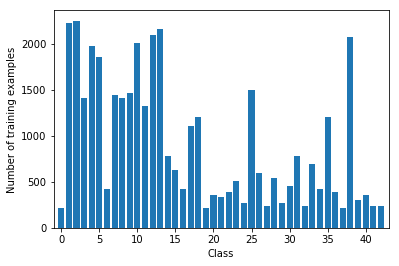

In [10]:
# 3. visualization
import random
import matplotlib.pyplot as plt
# read sign names
signnames = pd.read_csv('signnames.csv').values[:, 1]
# plot sign distribution
plt.bar( np.arange( 43 ), class_counts, align='center' )
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

In [11]:
dry_label = np.asarray(dry_label)
print(dry_label.shape)dry_label = np.asarray(dry_label)
print(dry_label.shape)from sklearn.utils import shuffle
from skimage import exposure
import warnings 

num_classes = 43

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    Assumes original dataset is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Dataset array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing dataset with {} examples:".format(X.shape[0]))

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # http://scikit-image.org/docs/dev/api/skimage.exposure.html
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(num_classes)[y]
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) # add one dimension 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_process_data(pickled_data_file):
    """
    Loads pickled data and preprocesses images and labels by scaling features, 
    shuffling the data and applying one-hot encoding to labels.
    
    Parameters
    ----------
    pickled_data_file  : string
                         Pickled data file name.
    Returns
    -------
    A tuple of X and y containing preloaded and preprocessed features and labels respectively.    
    """
    X, y = load_pickled_data(pickled_data_file, columns = ['features', 'labels'])
    X, y = preprocess_dataset(X, y)
    return (X, y)

## Data augmentation

In [ ]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import random

class AugmentedSignsBatchIterator(BatchIterator):
    """
    Iterates over dataset in batches. 
    Allows images augmentation by randomly rotating, applying projection, 
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """
        
    def __init__(self, batch_size, shuffle = False, seed = 42, p = 0.5, intensity = 0.5):
        """
        Initialises an instance with usual iterating settings, as well as data augmentation coverage
        and augmentation intensity.
        
        Parameters
        ----------
        batch_size:
                    Size of the iteration batch.
        shuffle   :
                    Flag indicating if we need to shuffle the data.
        seed      :
                    Random seed.
        p         :
                    Probability of augmenting a single example, should be in a range of [0, 1] .
                    Defines data augmentation coverage.
        intensity :
                    Augmentation intensity, should be in a [0, 1] range.
        
        Returns
        -------
        New batch iterator instance.
        """
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            yb
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)

        return Xb, yb
        
    def rotate(self, Xb, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 30. * self.intensity # scale by self.intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        depending on the size of the image. Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

        return Xb

## Test augmentation (10 examples)

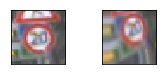

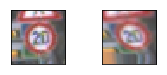

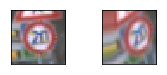

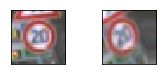

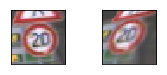

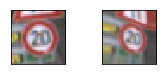

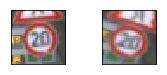

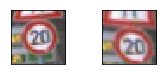

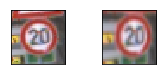

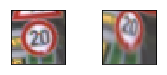

In [13]:
# record_iterator_train = tf.python_io.tf_record_iterator(path=TFRECORDS_TRAIN_NAME)
# train_images, train_labels = read_whole_dataset_from_tfrecords(record_iterator_train)
train_images = np.asarray(train_images, dtype='float32')
train_labels = np.asarray(train_labels, dtype='int32')
train_images = train_images / 255.

batch_iterator = AugmentedSignsBatchIterator(batch_size = 10, p = 1.0, intensity = 0.75)
for x_batch, y_batch in batch_iterator(train_images, train_labels):
    for i in range(10): 
        # plot two images:
        fig = plt.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(train_images[i])
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i])
        plt.show()
    break
train_images = (train_images * 255.).astype(np.uint8)

## Preprocessing for balance dataset

In [14]:
def flip_extend(X, y):
    """
    Extends existing images dataset by flipping images of some classes. As some images would still belong
    to same class after flipping we extend such classes with flipped images. Images of other would toggle 
    between two classes when flipped, so for those we extend existing datasets as well.
    
    Parameters
    ----------
    X       : ndarray
              Dataset array containing feature examples.
    y       : ndarray, optional, defaults to `None`
              Dataset labels in index form.

    Returns
    -------
    A tuple of X and y.    
    """
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

def extend_balancing_classes(X, y, aug_intensity = 0.5, counts = None):
    """
    Extends dataset by duplicating existing images while applying data augmentation pipeline.
    Number of generated examples for each class may be provided in `counts`.
    
    Parameters
    ----------
    X             : ndarray
                    Dataset array containing feature examples.
    y             : ndarray, optional, defaults to `None`
                    Dataset labels in index form.
    aug_intensity :
                    Intensity of augmentation, must be in [0, 1] range.
    counts        :
                    Number of elements for each class.
                    
    Returns
    -------
    A tuple of X and y.    
    """
    num_classes = 43

    _, class_counts = np.unique(y, return_counts = True)
    print(class_counts)
    max_c = max(class_counts)
    total = max_c * num_classes if counts is None else np.sum(counts)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = np.float32)
    y_extended = np.empty([0], dtype = y.dtype)
    print("Extending dataset using augmented data (intensity = {}):".format(aug_intensity))
    
    for c, c_count in zip(range(num_classes), class_counts):
        # How many examples should there be eventually for this class:
        max_c = max_c if counts is None else counts[c]
        # First copy existing data for this class
        X_source = (X[y == c] / 255.).astype(np.float32)
        y_source = y[y == c]
#         # if the number of existing data is greater than max_c
#         if (balanced == True and X_source.shape[0] > max_c):
#             X_source = X_source[0 : max_c, :, :, :]
#             y_source = y_source[0 : max_c]
        
        X_extended = np.append(X_extended, X_source, axis = 0)
        
#         if (balanced == True and X_source.shape[0] > max_c):
#             #print("x_extended: ", X_extended.shape[0], " reminder: ", X_extended.shape[0]%9000)
#             #print("max_c: {} c_count: {} first_add: {}".format(max_c, c_count, first_add))
#             continue
        # Second create more data
        first_add = max_c // c_count
        for i in range(first_add - 1):
            batch_iterator = AugmentedSignsBatchIterator(batch_size = X_source.shape[0], p = 1.0, intensity = aug_intensity)
            for x_batch, _ in batch_iterator(X_source, y_source):
                X_extended = np.append(X_extended, x_batch, axis = 0)
                #print_progress(X_extended.shape[0], total)
        batch_iterator = AugmentedSignsBatchIterator(batch_size = (max_c - first_add * c_count), p = 1.0, intensity = aug_intensity)
        for x_batch, _ in batch_iterator(X_source, y_source):
            X_extended = np.append(X_extended, x_batch, axis = 0)
            break
        print_progress(X_extended.shape[0], total)
        # Fill labels for added images set to current class.
        added = X_extended.shape[0] - y_extended.shape[0]
        y_extended = np.append(y_extended, np.full((added), c, dtype = int))
        #print("x_extended: ", X_extended.shape[0], " reminder: ", X_extended.shape[0]%9000)
        #print("max_c: {} c_count: {} first_add: {}".format(max_c, c_count, first_add))
    return ((X_extended * 255.).astype(np.uint8), y_extended)

## Generate 'balanced' and 'extended' dataset

In [15]:
import random
import pickle
from sklearn.cross_validation import train_test_split


print("Number of training examples in initial dataset =", train_images.shape[0])
_, class_counts = np.unique(train_labels, return_counts = True)
train_images, train_labels = flip_extend(train_images, train_labels)
print("Number of training examples after horizontal flipping =", train_images.shape[0])

# Prepare a dataset with balanced classes
train_balanced_images, train_balanced_labels = extend_balancing_classes(train_images, train_labels, aug_intensity = 0.75, counts = np.full(43, 9000, dtype = int))
train_balanced_images, train_balanced_labels = shuffle(train_balanced_images, train_balanced_labels)
print("\n")
print("Number of training examples after augmenting and balancing training data =", train_balanced_images.shape[0])
print("writing train balanced images to tfrecords.")
writer = tf.python_io.TFRecordWriter("GTSRB_train_balanced.tfrecords")
for example_idx in range(train_balanced_images.shape[0]):
    image_raw = train_balanced_images[example_idx].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(RESIZE_HEIGHT),
        'width': _int64_feature(RESIZE_WIDTH),
        'depth': _int64_feature(3),
        'label': _int64_feature(train_balanced_labels[example_idx]),
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())
writer.close()

# Prepare a dataset with extended classes
# _, class_counts = np.unique(train_labels, return_counts = True)
# train_extended_images, train_extended_labels = extend_balancing_classes(train_images, train_labels, aug_intensity = 0.75, counts = class_counts)
# train_extended_images, train_extended_labels = shuffle(train_extended_images, train_extended_labels)
# print("\n")
# print("Number of training examples after augmenting and extending training data =", train_extended_images.shape[0])
# print("writing train extended images to tfrecords.")
# writer = tf.python_io.TFRecordWriter("GTSRB_train_extended.tfrecords")
# for example_idx in range(train_extended_images.shape[0]):
#     image_raw = train_extended_images[example_idx].tostring()
#     example = tf.train.Example(features=tf.train.Features(feature={
#         'height': _int64_feature(RESIZE_HEIGHT),
#         'width': _int64_feature(RESIZE_WIDTH),
#         'depth': _int64_feature(3),
#         'label': _int64_feature(train_extended_labels[example_idx]),
#         'image_raw': _bytes_feature(image_raw)}))
#     writer.write(example.SerializeToString())
# writer.close()

Number of training examples in initial dataset = 39209
Number of training examples after horizontal flipping = 67378
[ 210 4440 2250 1410 1980 3720  420 1440 1410 1470 2010 2640 8400 4320  780
 2520  420 4440 2400  570  570  330  780  510  270 1500 1200  240  540  270
  900  780  480 1109 1109 2400  600  600 2370 2370  720  240  240]
Extending dataset using augmented data (intensity = 0.75):
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


Number of training examples after augmenting and balancing training data = 387000
writing train balanced images to tfrecords.


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


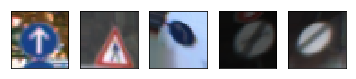

In [16]:
#############################################################################
# Read 'balanced' and 'extended' dataset
#############################################################################
# read sign names
signnames = pd.read_csv("signnames.csv").values[:, 1]
extended_train_data_path = 'GTSRB_train_balanced.tfrecords'
record_iterator_train_extended = tf.python_io.tf_record_iterator(path=extended_train_data_path)
# read from tfrecords, and convert list to numpy array.
train_images_extended, train_labels_extended = read_whole_dataset_from_tfrecords(record_iterator_train_extended, 387000)
train_images = np.asarray(train_images_extended, dtype='uint8')
train_labels = np.asarray(train_labels_extended, dtype='int32')
fig = plt.figure()
for i in range(5):
    # plot images:
    axis = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    axis.imshow(train_images[i, :, :, :])
plt.show()

In [17]:
# # read sign names
# signnames = pd.read_csv("signnames.csv").values[:, 1]
# plt.figure()
# plt.imshow(train_images[40000, :, :, :])
# plt.show()
# print(signnames[train_labels[40000]])

In [18]:
# returns symbolic label and image
extended_train_labels, extended_train_images = read_and_decode_single_example(extended_train_data_path)
# groups examples into batches randomly
images_batch_train, labels_batch_train = tf.train.shuffle_batch(
    [extended_train_images, extended_train_labels], batch_size=BATCH_SIZE,
    capacity=2000,
    min_after_dequeue=1000)
label_one_hot = tf.one_hot(labels_batch_train, depth=43, on_value=1, off_value=0, axis=-1, dtype=tf.int32)
is_training = tf.placeholder(tf.bool)

# Construct model (training)
pred = conv_net(images_batch_train, weights, biases, is_training)

# Calculate L2 regulization
weights_regularizers = [weights['wc1'], weights['wc2'], weights['wc3'], weights['wc4'], weights['wd1']]
regularizers_loss = tf.Variable(0.0, dtype=tf.float32)
for ln in range(len(weights_regularizers)):
    regularizers_loss += tf.nn.l2_loss(weights_regularizers[ln])
cost_nn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=label_one_hot))
cost = cost_nn + L2_LAMBDA * regularizers_loss

current_epoch = tf.Variable(0, trainable=False)  # count the number of epochs
if LEARNING_RATE_DECAY:
    # The third parameter 'decay_steps' represent how many steps update learning rate once
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE,
        current_epoch,
        1,
        DECAY_RATE,
        staircase=True)
else:
    learning_rate = LEARNING_RATE

# run optimizer and increase global_step
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=current_epoch)


# Evaluate model (testing)
# placeholder for testing data
images_placeholder_test = tf.placeholder(tf.uint8, shape=[None, RESIZE_HEIGHT, RESIZE_WIDTH, 3])
labels_placeholder_test = tf.placeholder(tf.int32, shape=[None, ])
images_placeholder_test_norm = tf.cast(images_placeholder_test, tf.float32) * (1. / 255) - 0.5
pred_test = conv_net(images_placeholder_test_norm, weights, biases, is_training)
correct = tf.nn.in_top_k(pred_test, labels_placeholder_test, 1)
# Return the number of true entries.
correct_sum = tf.reduce_sum(tf.cast(correct, tf.int32))


In [19]:
# iterator for testing
iter_test_ = data_test_iterator()
iter_train_ = data_train_iterator()
sess = tf.Session()
# Required. See below for explanation
init = tf.global_variables_initializer()
sess.run(init)
# start the queue runner (need to be called after initialization)
tf.train.start_queue_runners(sess=sess)

image_train_batch, labels_train_batch = next(iter_train_)
feed_dict = {
    images_placeholder_test: image_train_batch,
    labels_placeholder_test: labels_train_batch,
}
images_batch_train_run, labels_batch_train_run = sess.run([images_batch_train, labels_batch_train], feed_dict=feed_dict)


# pred_test_run = sess.run(pred_test, feed_dict=feed_dict)
# images_placeholder_test_norm_run = sess.run(images_placeholder_test_norm, feed_dict=feed_dict)
# labels_placeholder_test_run = sess.run(labels_placeholder_test, feed_dict=feed_dict)
# correct_run = sess.run(correct, feed_dict=feed_dict)
# correct_sum_run = sess.run(correct_sum, feed_dict=feed_dict)


In [20]:
# iterator for testing
iter_test_ = data_test_iterator()
iter_train_ = data_train_iterator()

sess = tf.Session()
# Required. See below for explanation
init = tf.global_variables_initializer()
sess.run(init)
# start the queue runner (need to be called after initialization)
tf.train.start_queue_runners(sess=sess)
learning_rate_list = []
train_loss_list = []
precision_train_list = []
precision_test_list = []
iter_per_epoch_test = test_images.shape[0] // BATCH_SIZE
num_examples_test = iter_per_epoch_test * BATCH_SIZE
iter_per_epoch_train = train_images.shape[0] // BATCH_SIZE
num_examples_train = iter_per_epoch_train * BATCH_SIZE
# save training result to text file
log_file = open('training_log.txt', 'w')
log_file.write("num_examples_test: {0}, num_examples_train: {1}\n".format(num_examples_test, num_examples_train))
for iter in range(MAX_ITERATION):
    print_progress(iter + 1, MAX_ITERATION)
    _, train_loss, learning_rate_run, regularizers_run = sess.run([optimizer, cost, learning_rate, regularizers_loss], feed_dict = {is_training : True})
    learning_rate_list.append(learning_rate_run)
    train_loss_list.append(train_loss)
    if iter % 100 == 0:
        # measure testing accuracy
        true_count_test = 0  # Counts the number of correct predictions.
        for val_with_test_data in range(iter_per_epoch_test):
            image_test_batch, labels_test_batch = next(iter_test_)
            feed_dict = {
                images_placeholder_test: image_test_batch,
                labels_placeholder_test: labels_test_batch,
                is_training: False
            }
            true_count_test += sess.run(correct_sum, feed_dict=feed_dict)
        precision_test = float(true_count_test) / num_examples_test

        # measure training accuracy
        true_count_train = 0  # Counts the number of correct predictions.
        for val_with_train_data in range(iter_per_epoch_train):
            image_train_batch, labels_train_batch = next(iter_train_)
            feed_dict = {
                images_placeholder_test: image_train_batch,
                labels_placeholder_test: labels_train_batch,
                is_training: False
            }
            true_count_train += sess.run(correct_sum, feed_dict=feed_dict)
        precision_train = float(true_count_train) / num_examples_train
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        #print("Iteration: {}, learning rate: {}, regularizer: {}".format(iter, learning_rate_run, regularizers_run))
        #print("num_examples_test: {0}, num_examples_train: {1}".format(num_examples_test, num_examples_train))
        #print("Training loss: {0}\tTesting Acc: {1}\tTraining Acc: {2}".format(train_loss, precision_test, precision_train))
        log_file.write("Iteration: {}, learning rate: {}, regularizer: {}\n".format(iter, learning_rate_run, regularizers_run))
        log_file.write("Training loss: {0}\tTesting Acc: {1}\tTraining Acc: {2}\n".format(train_loss, precision_test, precision_train))
        log_file.flush()
log_file.close()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%
